# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [ ]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [8]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Set random seed for reproducible loading
np.random.seed(502)

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Check TensorFlow version

In [9]:
f"TF version: {tf.__version__}."

'TF version: 2.5.0.'

### Check hardware connection

In [ ]:
from tensorflow.python.profiler import profiler_client

if tf.test.gpu_device_name():
    print("Found GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Found no GPU.")
try:
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print("Found TPU: {}".format(profiler_client.monitor(tpu_profile_service_address, 100, 2)))
except:
    print("Found no TPU.")

Found GPU: /device:GPU:0
Found no TPU.


## Initial training

### Load custom modules

In [ ]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [ ]:
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = 'FeCoNi_with_auger_9_classes_35ev_window'

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = 'regression',
                            intensity_only = True)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Model folder created at /20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window/model
Logs folder created at /20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window/logs
Figures folder created at /20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window/figures


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 351 features (X) + 9 labels (y)


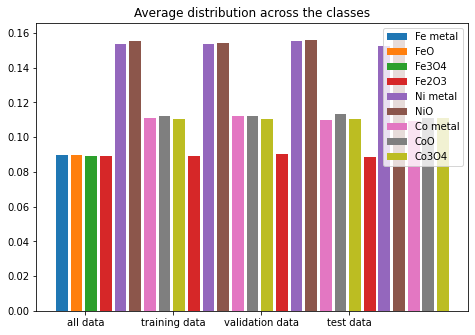

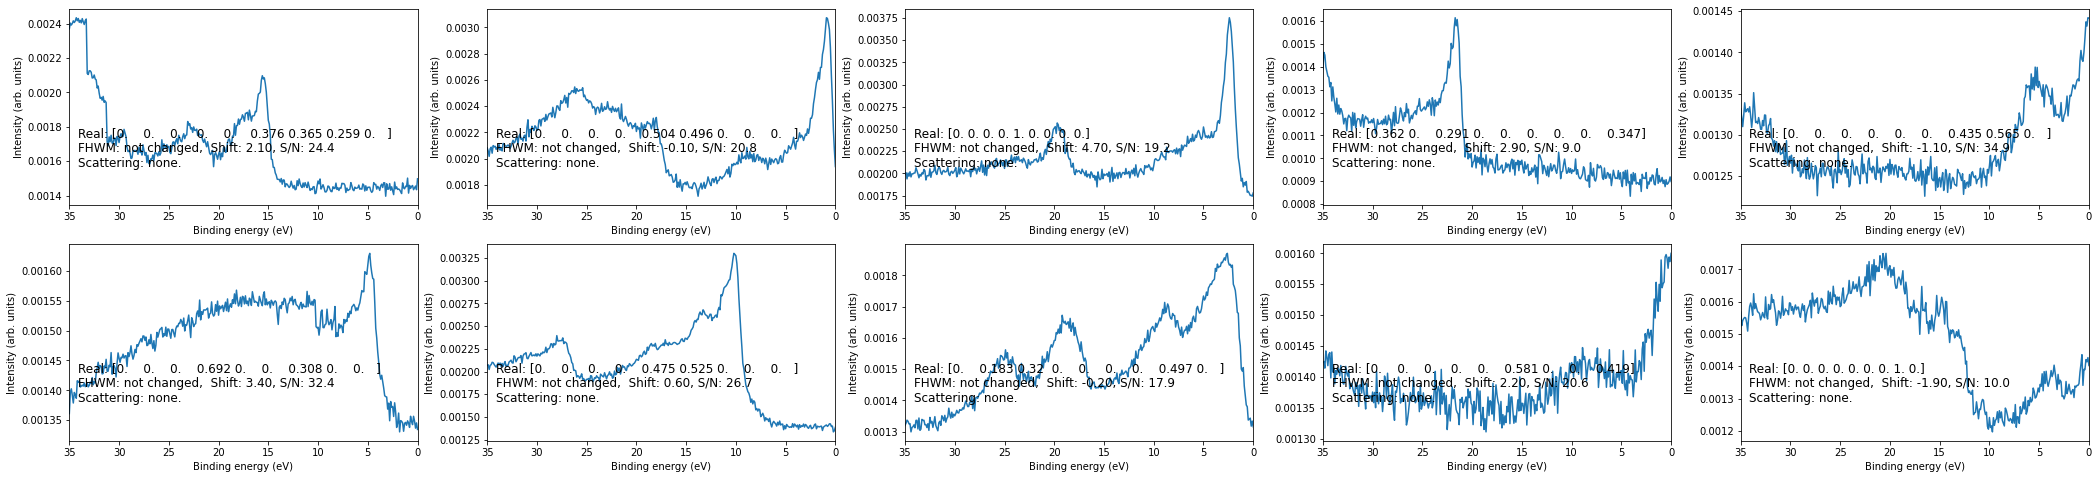

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210805_FeCoNi_with_auger_peaks_35ev_window.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [ ]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class RegressionCNN(models.EmptyModel):
    """A CNN for XPS data with mixed phases."""

    def __init__(self, inputshape, num_classes):
        """
        Initialize model with convolutional layers.
        
        A CNN with three convolutional layers of different kernel size 
        at the beginning. Works well for learning across scales.
        
        This is to be used for regression on all labels. -> sigmoid 
        activation in the last layer.
        """
        self.input_1 = layers.Input(shape=inputshape)

        self.conv_1_short = layers.Conv1D(
            filters=12,
            kernel_size=5,
            strides=1,
            padding="same",
            activation="relu",
            name="conv_1_short")(self.input_1)
        self.conv_1_medium = layers.Conv1D(
            filters=12,
            kernel_size=10,
            strides=1,
            padding="same",
            activation="relu",
            name="conv_1_medium")(self.input_1)
        self.conv_1_long = layers.Conv1D(
            filters=12,
            kernel_size=15,
            strides=1,
            padding="same",
            activation="relu",
            name="conv_1_long")(self.input_1)

        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = layers.Conv1D(
            filters=10,
            kernel_size=5,
            strides=1,
            padding="valid",
            activation="relu",
            name="conv_2")(merged_sublayers)
        self.conv_3 = layers.Conv1D(
            filters=10,
            kernel_size=5,
            strides=1,
            padding="valid",
            activation="relu",
            name="conv_3")(self.conv_2)
        self.average_pool_1 = layers.AveragePooling1D(
            name="average_pool_1")(self.conv_3)

        self.flatten_1 = layers.Flatten(name="flatten1")(self.average_pool_1)
        self.drop_1 = layers.Dropout(rate=0.2, name="drop_1")(self.flatten_1)
        self.dense_1 = layers.Dense(
            units=4000,
             activation="relu",
              name="dense_1")(self.drop_1)
        self.dense_2 = layers.Dense(
            units=num_classes, 
            activation="sigmoid",
             name="dense_2")(self.dense_1)

        self.output_norm = layers.Lambda(
            lambda x: x / tf.reshape(K.sum(x, axis=-1), (-1, 1)),
            name="output_normalization")(self.dense_2)

        no_of_inputs = len(sublayers)

        super(RegressionCNN, self).__init__(
            inputs=self.input_1,
            outputs=self.output_norm,
            inputshape=inputshape,
            num_classes=num_classes,
            no_of_inputs=no_of_inputs,
            name="RegressionCNN",
        )

#### Build the model

In [ ]:
clf.model = RegressionCNN(clf.datahandler.input_shape,
                          clf.datahandler.num_classes)

# =============================================================================
# clf.model = ResNet1D(clf.datahandler.input_shape,
#                      clf.datahandler.num_classess,
#                      ap=True)
# =============================================================================

# Alternative: Build model from available models in models.py
# =============================================================================
# clf.model = models.RegressionCNN(clf.datahandler.input_shape, 
#                                  clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================

### Compile and summarize the model

Model: "RegressionCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 351, 1)]     0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1D)           (None, 351, 12)      72          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1D)          (None, 351, 12)      132         input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1D)            (None, 351, 12)      192         input_1[0][0]                    
______________________________________________________________________________________

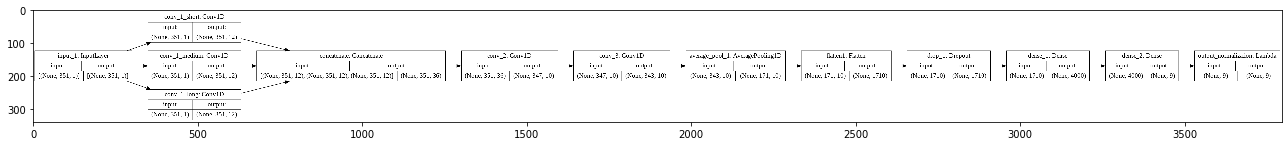

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.losses import CategoricalCrossentropy

learning_rate = 5e-05
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == 'regression':
    mae = MeanAbsoluteError()
    clf.model.compile(loss = mae, optimizer = optimizer)
    # =============================================================================
    # mse = MeanSquaredError()
    # clf.model.compile(loss = mse, optimizer = optimizer)
    # =============================================================================
    
elif clf.task == 'classification':
    categorical_crossentropy = CategoricalCrossentropy()
    clf.model.compile(loss = categorical_crossentropy,
                      optimizer = optimizer,
                      metrics = ['accuracy'])

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

625/625 [==============================] - 1s 2ms/step
Prediction done!
Train:
real: [0.    0.    0.    0.    0.627 0.    0.373 0.    0.   ] pred: [0.11110283 0.11111038 0.11110403 0.11111362 0.11111115 0.11111622
 0.11110861 0.11111816 0.11111502]
real: [0.    0.    0.    0.    0.672 0.    0.    0.328 0.   ] pred: [0.11110388 0.11111127 0.11110325 0.11111616 0.11110841 0.111114
 0.11110868 0.11111737 0.11111699]
real: [0.    0.    0.    0.    0.    0.    0.    0.589 0.411] pred: [0.11110535 0.11111122 0.11110511 0.11111415 0.11110867 0.11111435
 0.11110887 0.11111638 0.11111587]
real: [0. 1. 0. 0. 0. 0. 0. 0. 0.] pred: [0.11110667 0.1111112  0.11110683 0.11111313 0.11110993 0.11111344
 0.11110979 0.11111515 0.11111391]
real: [0. 0. 0. 0. 0. 0. 0. 0. 1.] pred: [0.11110528 0.11111137 0.11110575 0.11111332 0.11110931 0.11111441
 0.11110928 0.11111602 0.11111527]
Test:
real: [0.409 0.    0.302 0.288 0.    0.    0.    0.    0.   ] pred: [0.11110639 0.11111119 0.11110666 0.1111133  0.111109

### Train

In [ ]:
epochs = 500
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 1/500
2000/2000 [==============================] - 12s 5ms/step - loss: 0.1620 - val_loss: 0.1608
Epoch 2/500
2000/2000 [==============================] - 9s 5ms/step - loss: 0.1337 - val_loss: 0.1180
Epoch 3/500
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1177 - val_loss: 0.1179
Epoch 4/500
2000/2000 [==============================] - 9s 5ms/step - loss: 0.1168 - val_loss: 0.1174
Epoch 5/500
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1163 - val_loss: 0.1158
Epoch 6/500
2000/2000 [==============================] - 9s 5ms/step - loss: 0.1159 - val_loss: 0.1161
Epoch 7/500
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1154 - val_loss: 0.1159
Epoch 8/500
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1152 - val_loss: 0.1147
Epoch 9/500
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1146 - val_loss: 0.1140
Epoch 10/500
2000/2000 [==============================] - 9s 4ms/step - 

In [ ]:
epochs = 500
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 501/1000
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0765 - val_loss: 0.0781
Epoch 502/1000
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0765 - val_loss: 0.0778
Epoch 503/1000
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0765 - val_loss: 0.0782
Epoch 504/1000
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0765 - val_loss: 0.0782
Epoch 505/1000
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0764 - val_loss: 0.0786
Epoch 506/1000
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0764 - val_loss: 0.0778
Epoch 507/1000
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0764 - val_loss: 0.0781
Epoch 508/1000
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0762 - val_loss: 0.0782
Epoch 509/1000
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0763 - val_loss: 0.0781
Epoch 510/1000
2000/2000 [====================

### Plot loss

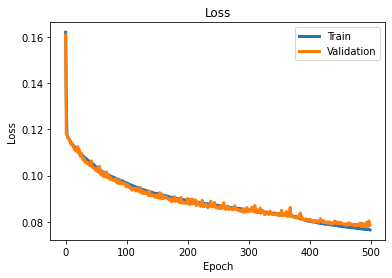

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

625/625 [==============================] - 1s 2ms/step - loss: 0.0780
Evaluation done! 

Test loss: 0.07801373


###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

625/625 [==============================] - 1s 2ms/step
Prediction done!


In [ ]:
print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test[i]))

Train:
real: [0.    0.    0.    0.    0.627 0.    0.373 0.    0.   ] pred: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6172436e-01
 1.6833409e-06 4.5326501e-04 4.3776867e-01 5.2089410e-05]
real: [0.    0.    0.    0.    0.672 0.    0.    0.328 0.   ] pred: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9993932e-01
 6.0503815e-05 1.8812913e-09 1.4412534e-07 1.1928703e-37]
real: [0.    0.    0.    0.    0.    0.    0.    0.589 0.411] pred: [1.5582855e-05 4.5388337e-05 1.0254557e-03 4.0315896e-05 4.4223978e-04
 1.3663317e-04 9.7866647e-02 3.1722891e-01 5.8319873e-01]
real: [0. 1. 0. 0. 0. 0. 0. 0. 0.] pred: [1.2441749e-01 2.9598257e-01 3.4796688e-01 2.2806355e-01 2.3400160e-07
 8.6507468e-10 2.3059947e-03 5.3484039e-04 7.2848517e-04]
real: [0. 0. 0. 0. 0. 0. 0. 0. 1.] pred: [3.2569580e-03 7.6342105e-05 9.8343291e-05 3.2030566e-05 2.3137648e-03
 1.5443177e-02 6.2845372e-02 2.0407599e-01 7.1185803e-01]
Test:
real: [0.409 0.    0.302 0.288 0.    0.    0.    0.    0

### Show some predictions

#### 10 random training samples

Calculating loss for each example...
Done!


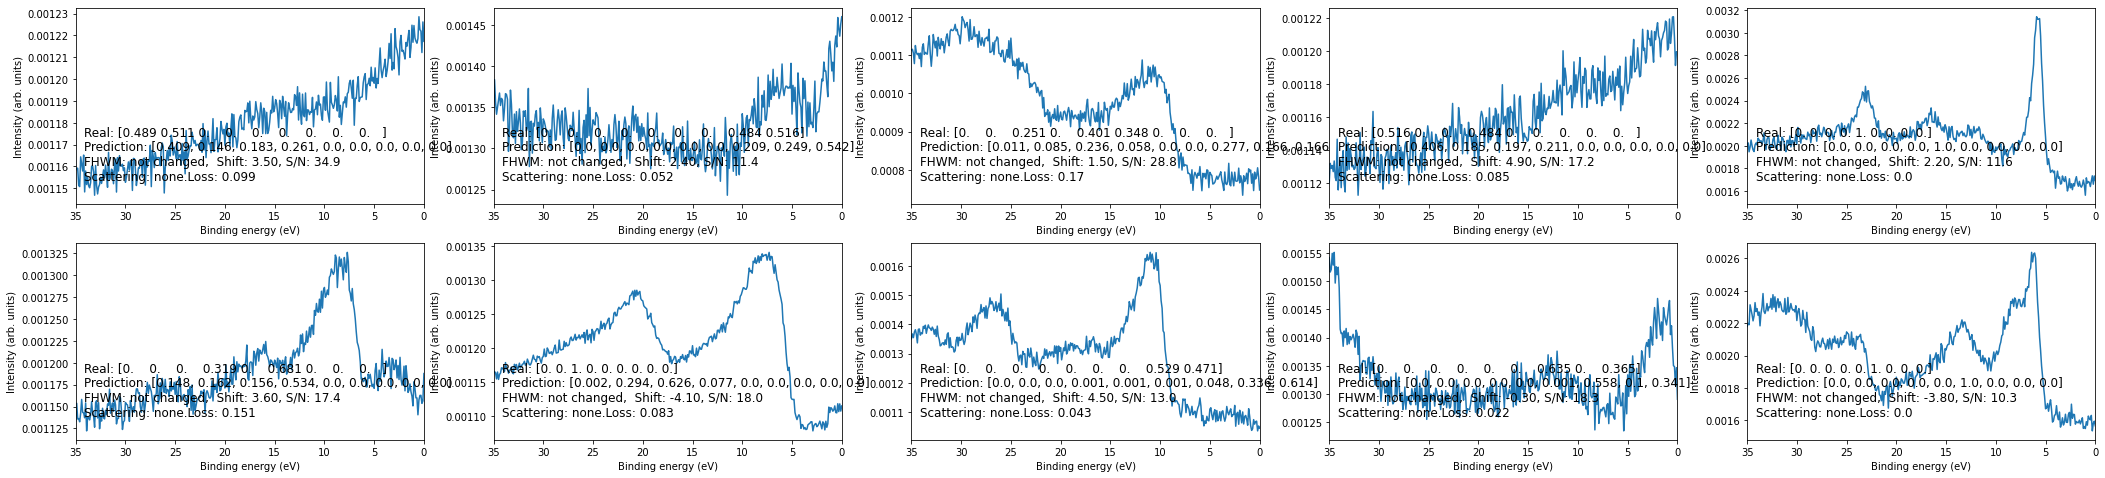

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and results

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Continue training

### Load custom modules

In [10]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')

<module 'xpsdeeplearning.network.classifier' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/classifier.py'>

<module 'xpsdeeplearning.network.utils' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/utils.py'>


 Modules were reloaded.


### Reload classifier from previous run

In [11]:
runpath = r'/content/drive/My Drive/deepxps/runs/20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window'
clf = classifier.restore_clf_from_logs(runpath)

Model folder was already at /20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window/model
Logs folder was already at /20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window/logs
Figures folder was already at /20210811_09h34m_FeCoNi_with_auger_9_classes_35ev_window/figures
Recovered classifier from file.


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 351 features (X) + 9 labels (y)


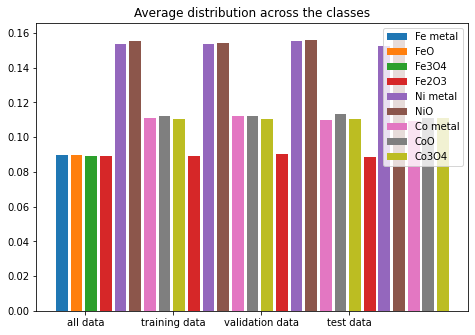

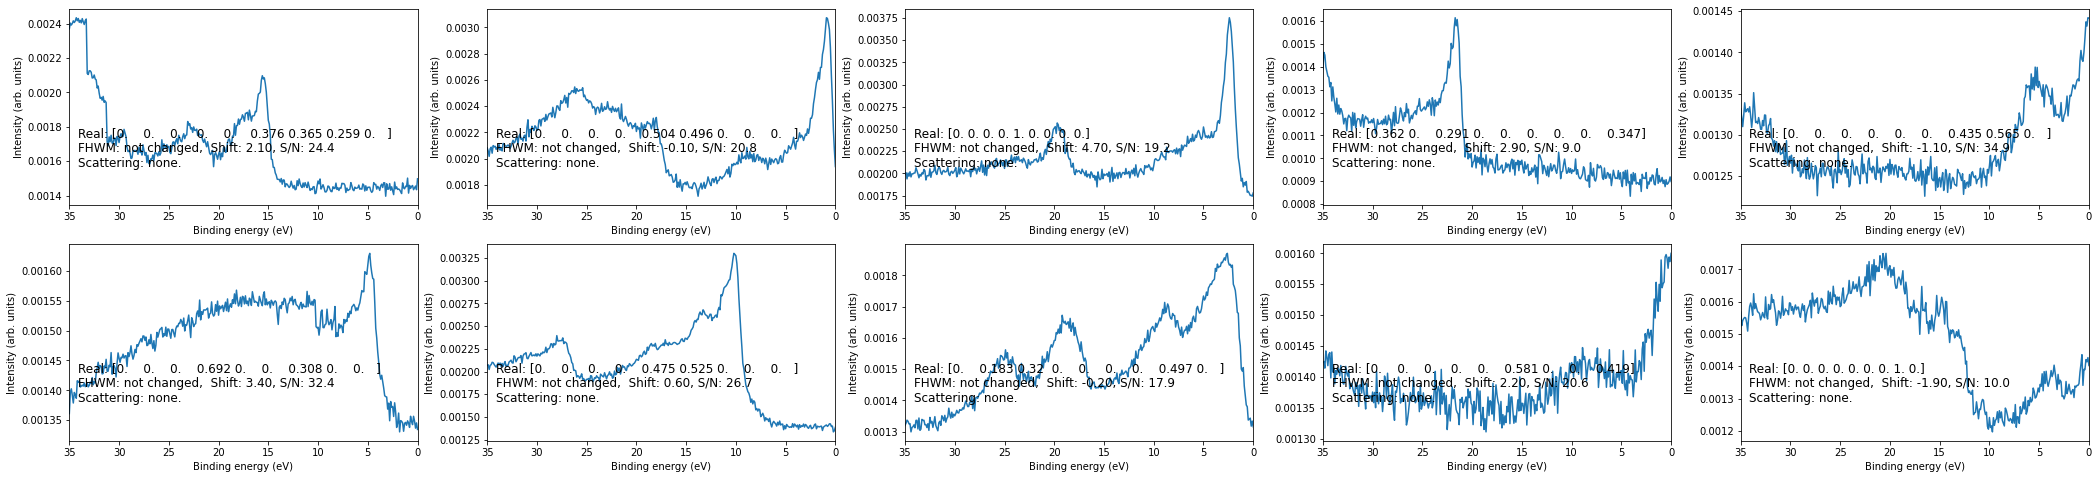

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = clf.logging.hyperparams['input_filepath'],
                                 no_of_examples = clf.logging.hyperparams['no_of_examples'],
                                 train_test_split = clf.logging.hyperparams['train_test_split'],
                                 train_val_split = clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [13]:
clf.load_model(compile_model = True)

Loaded model from disk.


### Summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 351, 1)]     0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1D)           (None, 351, 12)      72          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1D)          (None, 351, 12)      132         input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1D)            (None, 351, 12)      192         input_1[0][0]                    
_______________________________________________________________________________________

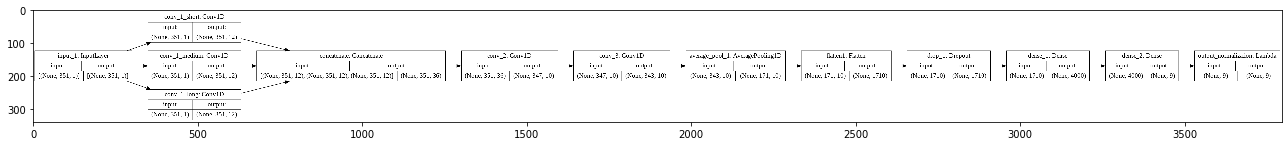

In [16]:
# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

In [ ]:
### Current alternative ### 
# Use the same model defined above and load the weights independently
# Need to run the cell with the definition of the model class above once
model_class = RegressionCNN # CHANGE HERE

clf.model = model_class(inputshape=clf.datahandler.input_shape,
                        num_classes=clf.datahandler.num_classes)

# LOAD WEIGHTS
weights_file = os.path.join(clf.logging.model_dir,
                            "weights.h5")
clf.model.load_weights(weights_file)

# Compile and summarize the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import CategoricalCrossentropy

learning_rate = clf.logging.hyperparams["learning_rate"]
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == "regression":
    mae = MeanAbsoluteError()
    clf.model.compile(loss=mae,
                      optimizer=optimizer,
                      metrics=["mae"])
    
elif clf.task == "classification":
    categorical_crossentropy = CategoricalCrossentropy()
    clf.model.compile(loss=categorical_crossentropy,
                      optimizer=optimizer,
                      metrics=["accuracy",
                               "categorical_crossentropy"])

### Show predictions with current model

In [17]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

625/625 [==============================] - 1s 2ms/step
Prediction done!
Train:
real: [0.    0.    0.    0.    0.627 0.    0.373 0.    0.   ] pred: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
 4.9592908e-24 3.3063689e-08 5.0000000e-01 4.5974364e-17]
real: [0.    0.    0.    0.    0.672 0.    0.    0.328 0.   ] pred: [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
 8.270550e-12 3.384495e-36 7.743235e-34 0.000000e+00]
real: [0.    0.    0.    0.    0.    0.    0.    0.589 0.411] pred: [5.1976916e-14 5.0257075e-08 1.7976174e-05 2.8480243e-05 2.9276974e-08
 1.2744103e-10 9.8855514e-03 4.8945737e-01 5.0061047e-01]
real: [0. 1. 0. 0. 0. 0. 0. 0. 0.] pred: [2.0633796e-02 3.8032052e-01 3.9647293e-01 2.0093909e-01 1.4298414e-11
 7.0215012e-15 2.8724535e-04 1.5412527e-04 1.1923540e-03]
real: [0. 0. 0. 0. 0. 0. 0. 0. 1.] pred: [1.3745838e-05 2.9674911e-07 3.5133851e-07 3.5523574e-04 3.1616069e-05
 7.0617977e-03 2.3093952e-02 3.8677394e-02 9.3076557e-01]

### Train

In [ ]:
epochs = 500

new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

### Train

In [ ]:
epochs = 1000

new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Plot loss

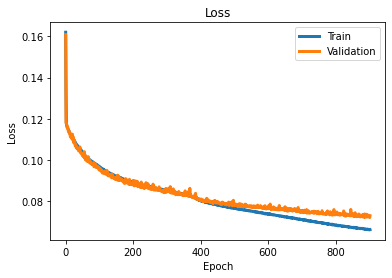

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

625/625 [==============================] - 16s 25ms/step
Prediction done!


### Show some predictions

#### 10 random training samples

Calculating loss for each example...
Done!


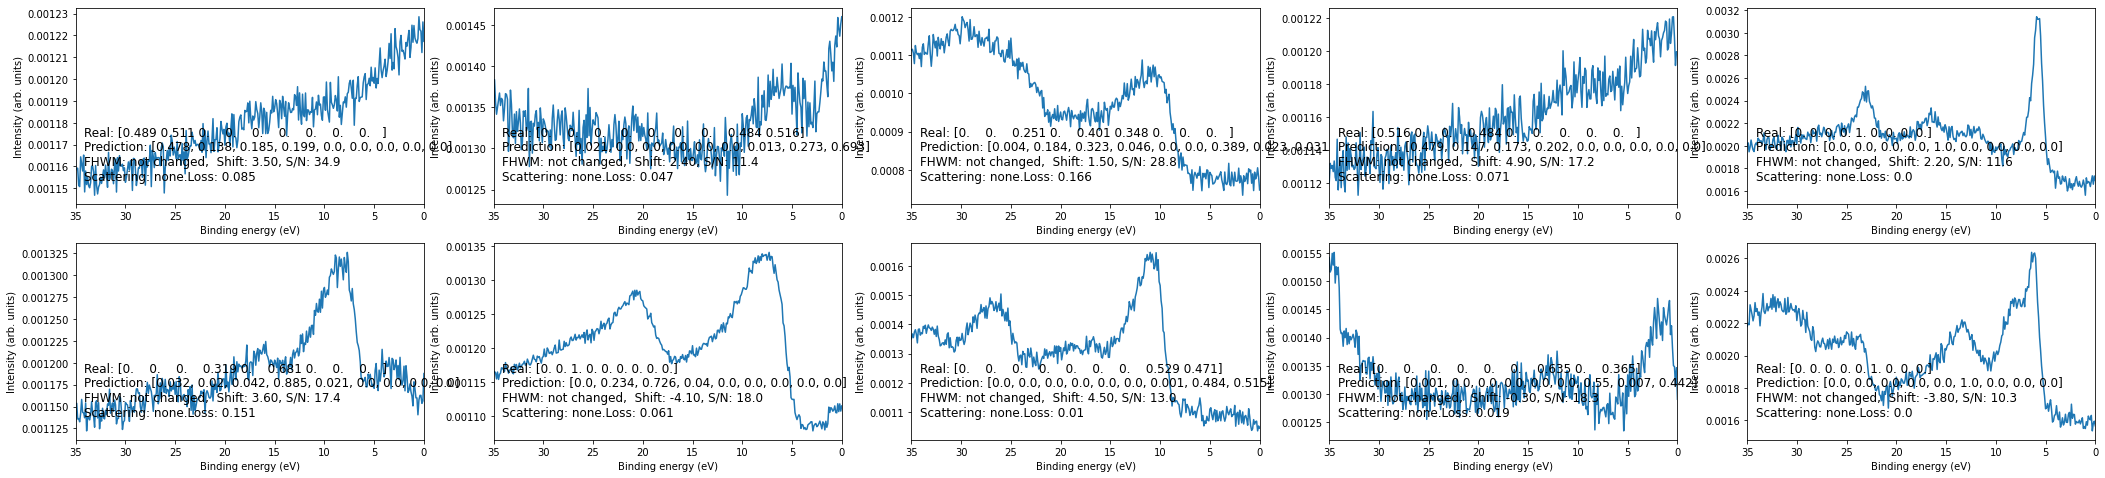

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

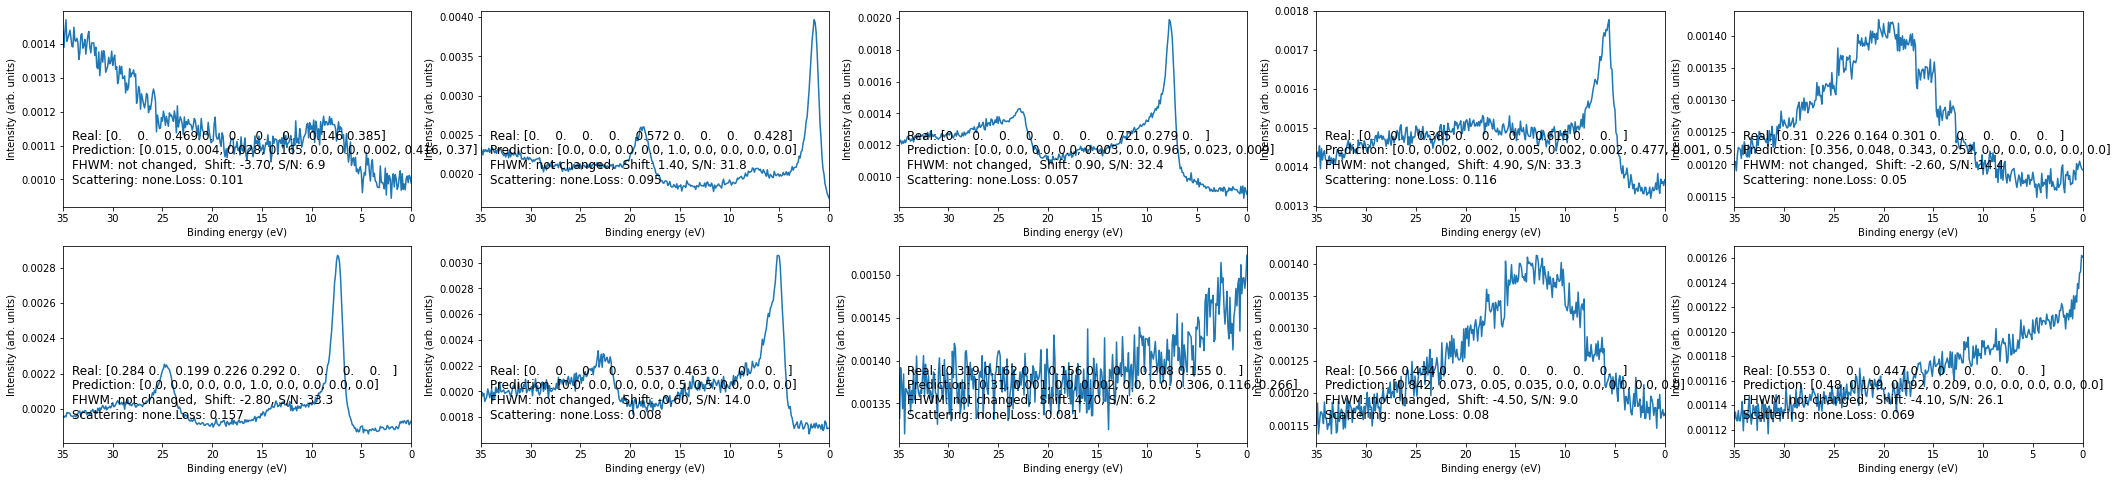

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

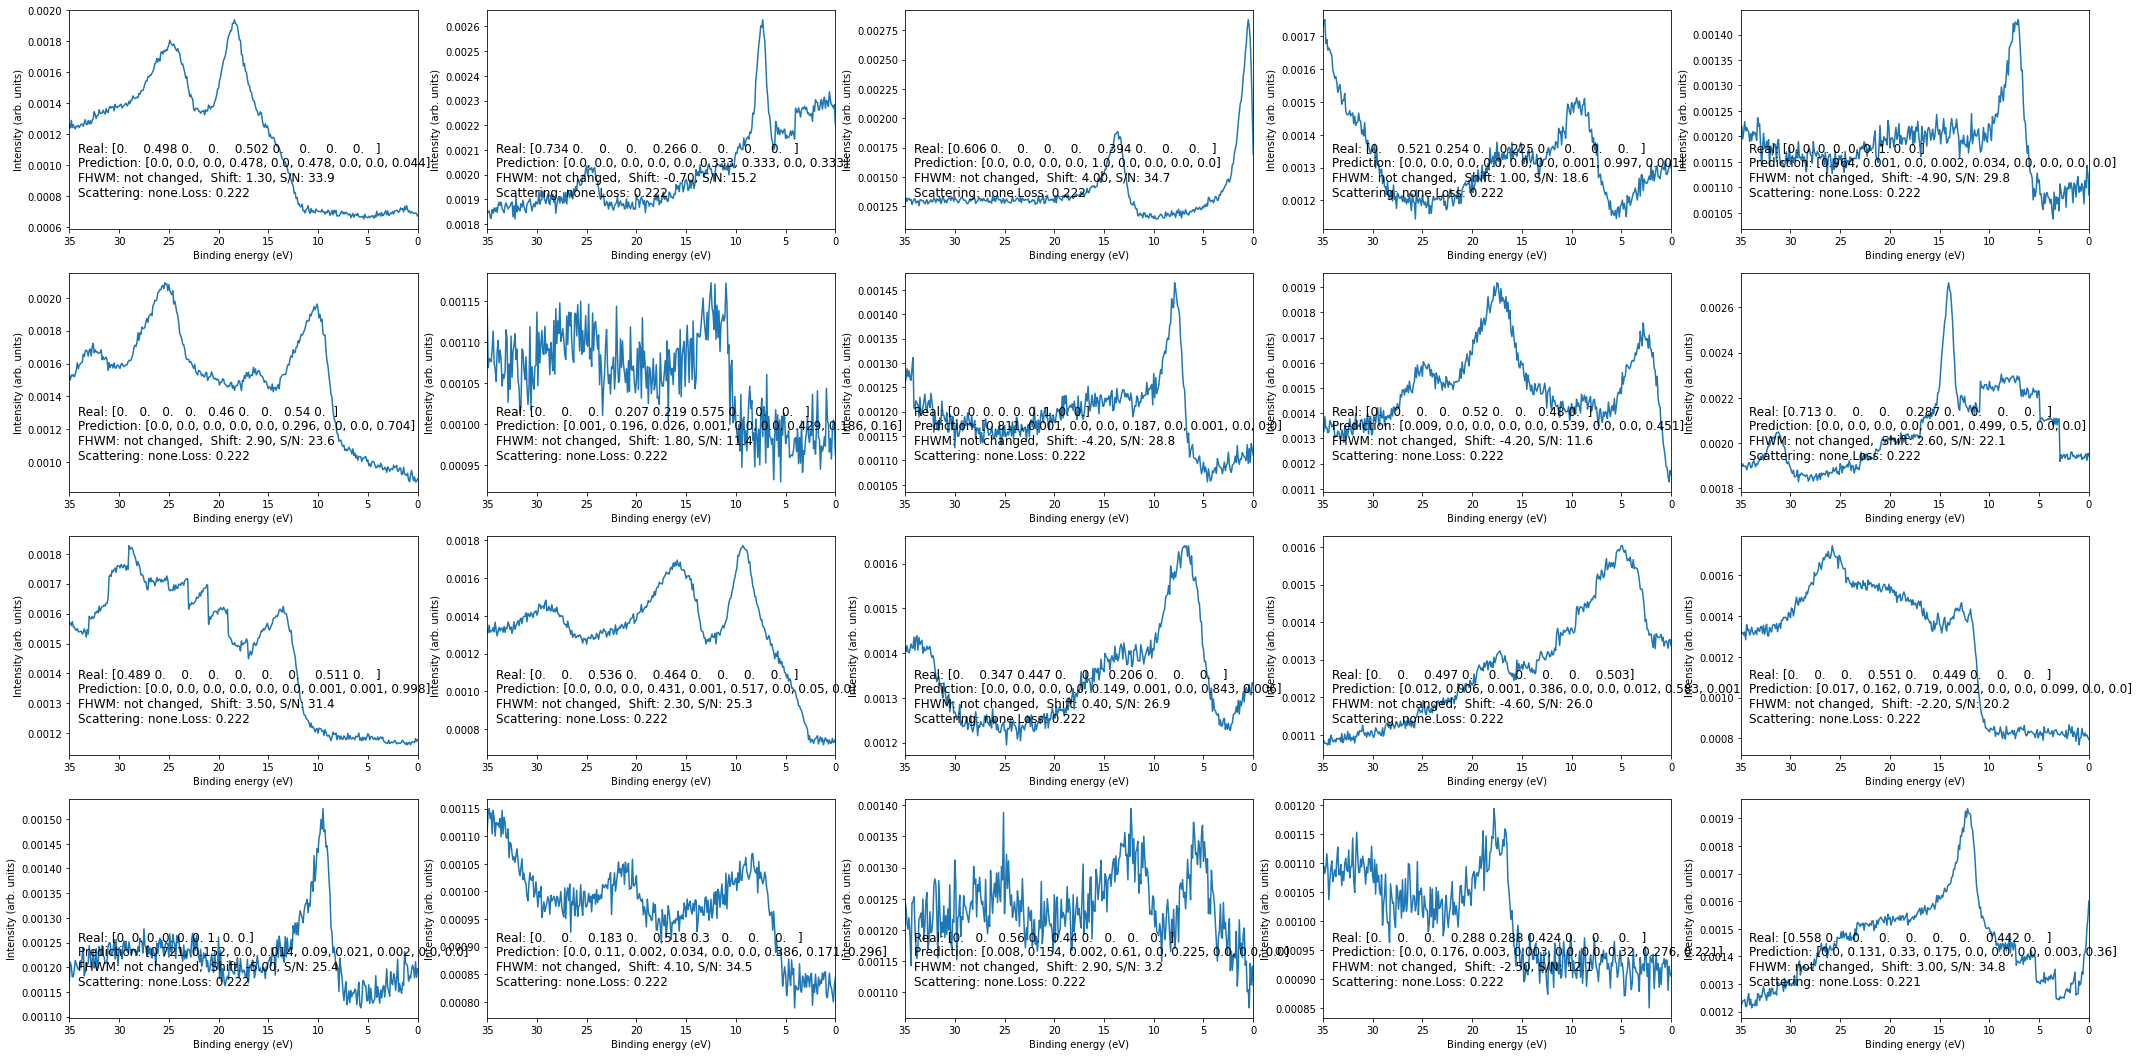

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

Report saved!


## Prepare website upload

In [ ]:
from xpsdeeplearning.network.prepare_upload import Uploader

dataset_path = clf.logging.hyperparams["input_filepath"].rsplit(".",1)[0] + "_metadata.json"
uploader = Uploader(clf.logging.root_dir, dataset_path)
uploader.prepare_upload_params()
uploader.save_upload_params()

JSON file was prepared for upload!


## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/train.ipynb'
output_file = os.path.join(clf.logging.log_dir,'train_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
